In [57]:
import pandas as pd
import numpy as np
from lifelines.datasets import load_waltons
import matplotlib.pyplot as plt

df = load_waltons()

df = df.sort_values(by="T")

print(df.head())
print(df.tail())
print(df.shape)

      T  E    group
0   6.0  1  miR-137
88  7.0  1  control
89  7.0  0  control
19  9.0  1  miR-137
18  9.0  1  miR-137
        T  E    group
49   69.0  1  control
48   69.0  1  control
58   69.0  1  control
132  69.0  1  control
77   75.0  1  control
(163, 3)


In [81]:
df_new: pd.DataFrame = df.groupby("T").agg({"group": "count"}).reset_index()
df_new.columns = ["t", "d"]
df_new["n"] = df_new["d"][::-1].cumsum()[::-1]
print(df_new.head())
print(df_new.tail())

      t  d    n
0   6.0  1  163
1   7.0  2  162
2   9.0  3  160
3  13.0  3  157
4  15.0  2  154
       t   d   n
27  63.0   9  36
28  66.0   3  27
29  68.0  10  24
30  69.0  13  14
31  75.0   1   1


In [82]:
max_time = df_new["t"].max().astype(int)
max_n = df_new["n"].max().astype(int)

# Create a spine of time missing snapshots
df_spine = pd.DataFrame({"t": range(0, max_time + 1)})
df_snapshot = df_spine.merge(df_new, on="t", how="left")

# Fill in the missing values
df_snapshot["d"] = df_snapshot["d"].fillna(0)
df_snapshot = df_snapshot.bfill()

print(df_snapshot.head())
print(df_snapshot.tail())

   t    d      n
0  0  0.0  163.0
1  1  0.0  163.0
2  2  0.0  163.0
3  3  0.0  163.0
4  4  0.0  163.0
     t    d    n
71  71  0.0  1.0
72  72  0.0  1.0
73  73  0.0  1.0
74  74  0.0  1.0
75  75  1.0  1.0


In [83]:
df_calc = df_snapshot.copy()

df_calc["surv_in_period"] = 1 - df_calc["d"] / df_calc["n"]
df_calc["surv_over_time"] = df_calc["surv_in_period"].cumprod()

print(df_calc.head())
print(df_calc.tail())

   t    d      n  surv_in_period  surv_over_time
0  0  0.0  163.0             1.0             1.0
1  1  0.0  163.0             1.0             1.0
2  2  0.0  163.0             1.0             1.0
3  3  0.0  163.0             1.0             1.0
4  4  0.0  163.0             1.0             1.0
     t    d    n  surv_in_period  surv_over_time
71  71  0.0  1.0             1.0        0.006135
72  72  0.0  1.0             1.0        0.006135
73  73  0.0  1.0             1.0        0.006135
74  74  0.0  1.0             1.0        0.006135
75  75  1.0  1.0             0.0        0.000000


Text(0, 0.5, 'Survival Probability')

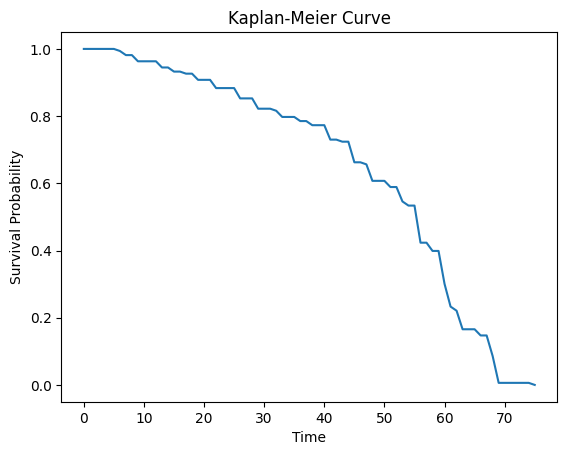

In [84]:
plt.plot(df_calc["t"], df_calc["surv_over_time"])
plt.title("Kaplan-Meier Curve")
plt.xlabel("Time")
plt.ylabel("Survival Probability")

In [85]:
# greenwood formula
df_calc["var_term"] = df_calc["d"] / (df_calc["n"] * (df_calc["n"] - df_calc["d"]))
df_calc["var_term_cs"] = df_calc["var_term"].cumsum()
df_calc["var"] = df_calc["var_term_cs"] * df_calc["surv_over_time"] ** 2

df_calc["std_err"] = np.sqrt(df_calc["var"])
df_calc["upper_ci"] = df_calc["surv_over_time"] + 1.96 * df_calc["std_err"]
df_calc["upper_ci"] = df_calc["upper_ci"].clip(upper=1)
df_calc["lower_ci"] = df_calc["surv_over_time"] - 1.96 * df_calc["std_err"]
df_calc["lower_ci"] = df_calc["lower_ci"].clip(lower=0)

# remove last row
df_calc = df_calc.iloc[:-1]

print(df_calc.head())
print(df_calc.tail())

   t    d      n  surv_in_period  surv_over_time  var_term  var_term_cs  var  \
0  0  0.0  163.0             1.0             1.0       0.0          0.0  0.0   
1  1  0.0  163.0             1.0             1.0       0.0          0.0  0.0   
2  2  0.0  163.0             1.0             1.0       0.0          0.0  0.0   
3  3  0.0  163.0             1.0             1.0       0.0          0.0  0.0   
4  4  0.0  163.0             1.0             1.0       0.0          0.0  0.0   

   std_err  upper_ci  lower_ci  
0      0.0       1.0       1.0  
1      0.0       1.0       1.0  
2      0.0       1.0       1.0  
3      0.0       1.0       1.0  
4      0.0       1.0       1.0  
     t    d    n  surv_in_period  surv_over_time  var_term  var_term_cs  \
70  70  0.0  1.0             1.0        0.006135       0.0     0.993865   
71  71  0.0  1.0             1.0        0.006135       0.0     0.993865   
72  72  0.0  1.0             1.0        0.006135       0.0     0.993865   
73  73  0.0  1.0     

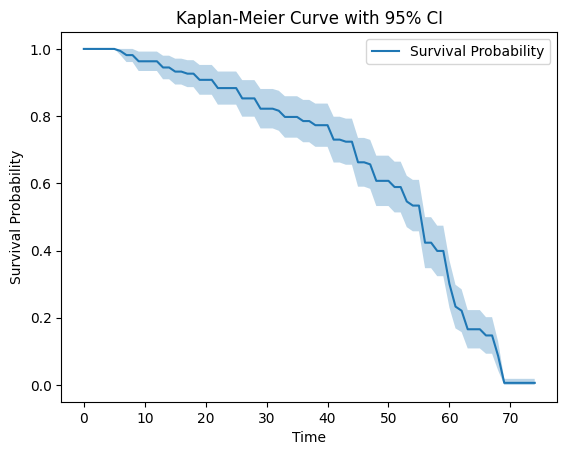

In [86]:
plt.plot(df_calc["t"], df_calc["surv_over_time"], label="Survival Probability")
plt.fill_between(df_calc["t"], df_calc["lower_ci"], df_calc["upper_ci"], alpha=0.3)
plt.title("Kaplan-Meier Curve with 95% CI")
plt.xlabel("Time")
plt.ylabel("Survival Probability")
plt.legend()

Text(0, 0.5, 'Number of subjects')

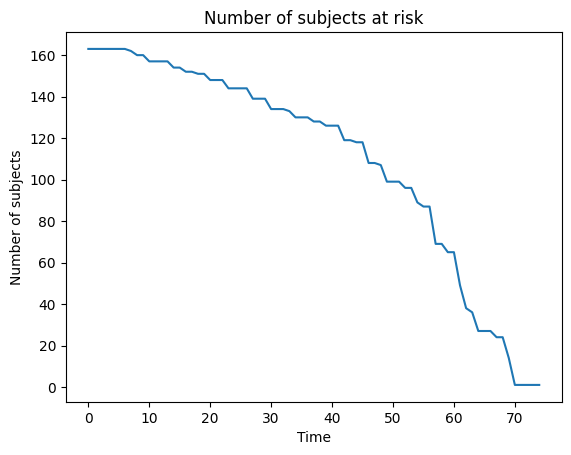

In [106]:
plt.plot(df_calc["t"], df_calc["n"])
plt.title("Number of subjects at risk")
plt.xlabel("Time")
plt.ylabel("Number of subjects")

### avg life

In [99]:
df["T"].mean()

49.61349693251534

In [103]:
(
    (df_calc["surv_over_time"].shift(1) - df_calc["surv_over_time"]).fillna(0)
    * df_calc["t"]
).sum()

49.15337423312883

In [104]:
((df_calc["upper_ci"].shift(1) - df_calc["upper_ci"]).fillna(0) * df_calc["t"]).sum()

51.86650068827768

In [105]:
((df_calc["lower_ci"].shift(1) - df_calc["lower_ci"]).fillna(0) * df_calc["t"]).sum()

46.026104457219844